# Gaia DR2 variability catalogs
## Part IV: Compare K2-derived period with Gaia-periods

In this notebook we quantify the rotation period differences between Gaia and K2.

gully  
May 3, 2018

In [1]:
# %load /Users/obsidian/Desktop/defaults.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
df_single = pd.read_csv('../data/analysis/k2_gaia_rotmod_single.csv')

In [6]:
df_single.shape

(224, 8)

In [8]:
df_single.head()

,source_id,epic_number,tm_name,k2_campaign_str,num_segments,best_rotation_period,amplitude_linear,multiplicity
0,2.449853e+18,60019808.0,2MASS J00011844-0050338,E,3,11.812471,0.991231,1
1,2.449853e+18,60020260.0,2MASS J00011919-0050496,E,3,11.812471,0.991231,1
2,3.595663e+18,201103864.0,2MASS J11581545-0628544,10,6,11.677781,0.990946,1
3,3.597348e+18,201149128.0,2MASS J12041716-0518533,10,3,2.062601,0.975344,1
4,3.598101e+18,201205375.0,2MASS J12080464-0358396,10,3,35.318797,0.992941,1


Let's determine the K2 period for each source and plot it against the Gaia period.

In [10]:
df_single['k2_period'] = 0.0

In [11]:
from lightkurve import KeplerLightCurveFile

In [39]:
k2_lc = KeplerLightCurveFile.from_archive(201103864.0)
lc = k2_lc.get_lightcurve('SAP_FLUX')

INFO: Found cached file ./mastDownload/K2/ktwo201103864-c10_lc/ktwo201103864-c102_llc.fits with expected size 368640. [astroquery.query]


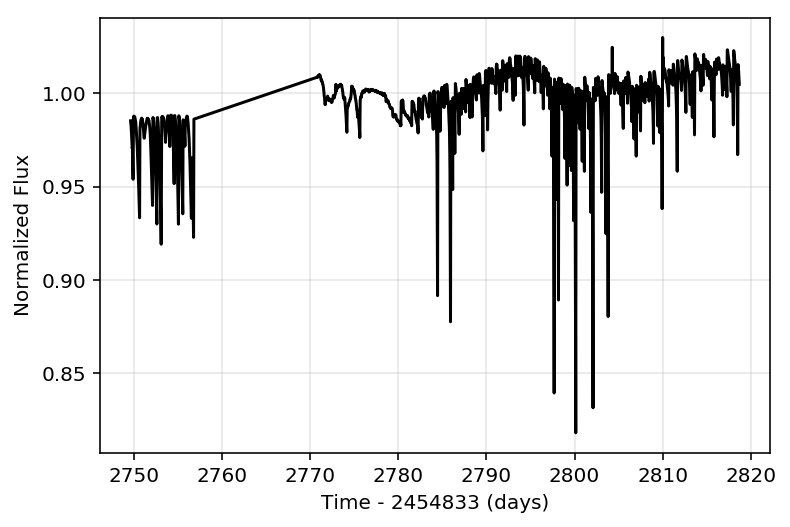

In [40]:
lc.plot()

In [14]:
from gatspy import periodic

In [19]:
import lightkurve

In [41]:
x_lims = (11.8/3, 11.8*3)
model = periodic.LombScargle()
model.optimizer.period_range = x_lims

gi = (lc.time == lc.time) & (lc.flux == lc.flux)

time = lc.time[gi]
flux = lc.flux[gi]
flux_err = flux*0.0+np.nanmedian(flux)

model.fit(time, flux, flux_err)

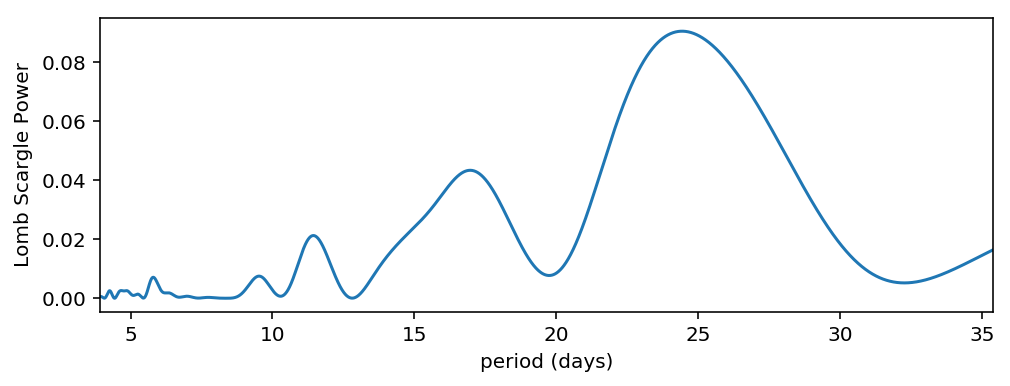

In [42]:
periods = np.linspace(*x_lims, 10000)

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    scores = model.score(periods)

# Plot the results
fig, ax = plt.subplots(figsize=(8, 3))
fig.subplots_adjust(bottom=0.2)
ax.plot(periods, scores)
ax.set(xlabel='period (days)', ylabel='Lomb Scargle Power',
       xlim=x_lims);

Gaia [Documentation section 14.3.6](https://gea.esac.esa.int/archive/documentation/GDR2/Gaia_archive/chap_datamodel/sec_dm_variability_tables/ssec_dm_vari_rotation_modulation.html) explains that some of the columns are populated with *arrays*!  So this catalog can be thought of as a **table-of-tables**.  The typical length of the tables are small, usually just 3-5 entries.

In [6]:
df0.num_segments.describe()

count    867.000000
mean       4.173010
std        2.019549
min        2.000000
25%        3.000000
50%        3.000000
75%        5.000000
max       11.000000
Name: num_segments, dtype: float64

In [7]:
df0.loc[1]

solution_id                                                           369295549951641967
source_id                                                             465678461815126784
num_segments                                                                           2
segments_start_time                               (2207.368642951862, 1702.825995034191)
segments_end_time                               (2316.4045885307028, 2316.4045885307028)
segments_colour_mag_intercept                  (-50.094787274038154, -36.16323154910394)
segments_colour_mag_intercept_error              (34.55610214479653, 17.249166642259794)
segments_colour_mag_slope                       (2.8918922153964335, 2.1154336243891634)
segments_colour_mag_slope_error                   (1.9194992883441295, 0.95817078987832)
segments_correlation_coefficient                (0.3432064980018941, 0.3635754393410782)
segments_correlation_significance               (0.150272879305833, 0.03454667362405828)
num_outliers         

I think the segments further consist of lightcurves, for which merely the summary statistics are listed here, but I'm not sure.

Since all the files are still only 150 MB, we can just read in all the files and concatenate them.

In [8]:
import glob

In [9]:
fns = glob.glob('../data/dr2/Gaia/gdr2/vari_rotation_modulation/csv/VariRotationModulation_*.csv.gz')

In [10]:
n_files = len(fns)

This step only takes a few seconds.  Let's use a progress bar to keep track.

In [11]:
from astropy.utils.console import ProgressBar

In [12]:
df_rotmod = pd.DataFrame()
with ProgressBar(n_files, ipython_widget=True) as bar:
    for i, fn in enumerate(fns):
        df_i = pd.read_csv(fn)
        df_rotmod = df_rotmod.append(df_i, ignore_index=True)
        bar.update()

A Jupyter Widget

In [13]:
df_rotmod.shape

(147535, 40)

We have 147,535 rotationally modulated variable stars.  What is the typical number of segments across the entire catalog?

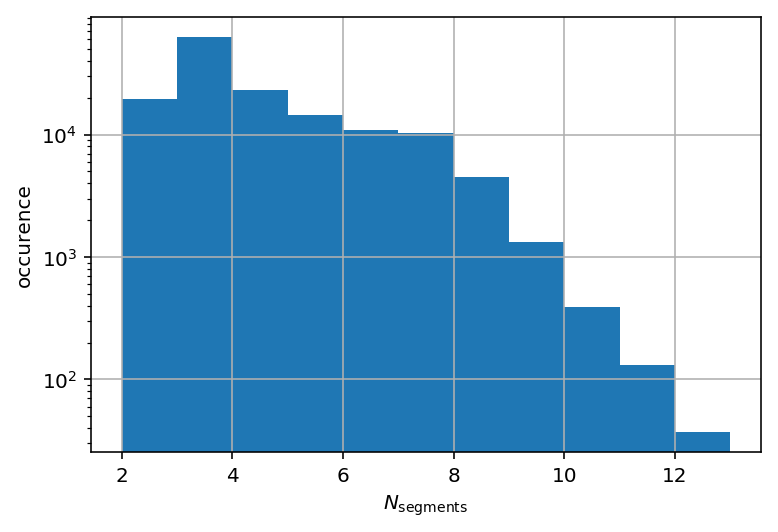

In [14]:
df_rotmod.num_segments.hist(bins=11)
plt.yscale('log')
plt.xlabel('$N_{\mathrm{segments}}$')
plt.ylabel('occurence');

What are these segments?  Are they the arbitrary Gaia segments, or are they something else?

Let's ask our first question:  **What are the distribution of periods?**

>`best_rotation_period` : Best rotation period (double, Time[day])

>this field is an estimate of the stellar rotation period and is obtained by averaging the periods obtained in the different segments 

Text(0,0.5,'$N$')

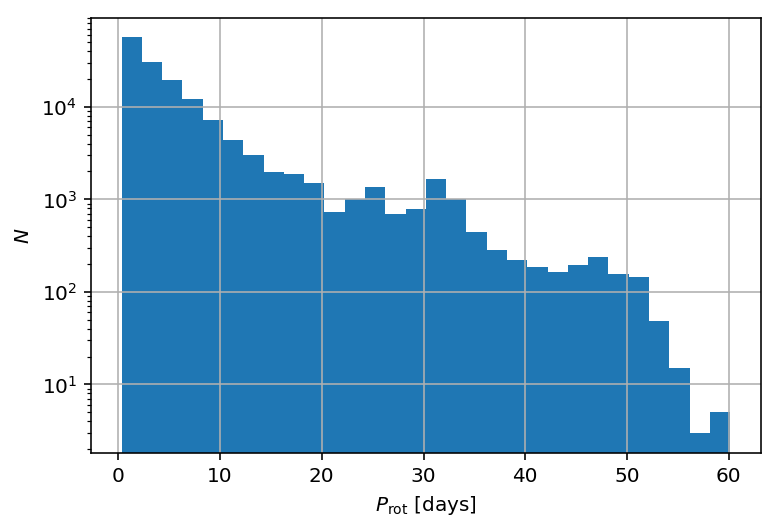

In [15]:
df_rotmod.best_rotation_period.hist(bins=30)
plt.yscale('log')
plt.xlabel('$P_{\mathrm{rot}}$ [days]')
plt.ylabel('$N$')

Next up: **What are the distribution of amplitudes?**

We will use the `segments_activity_index`:

> segments_activity_index : Activity Index in segment (double, Magnitude[mag])

>this array stores the activity indexes measured in the different segments. In a given segment the amplitude of variability A is taken as an index of the magnetic activity level. The amplitude of variability is measured by means of the equation:

$$A=mag_{95}−mag_{5}$$
> where $mag_{95}$ and $mag_{5}$ are the 95-th and the 5-th percentiles of the G-band magnitude values. 


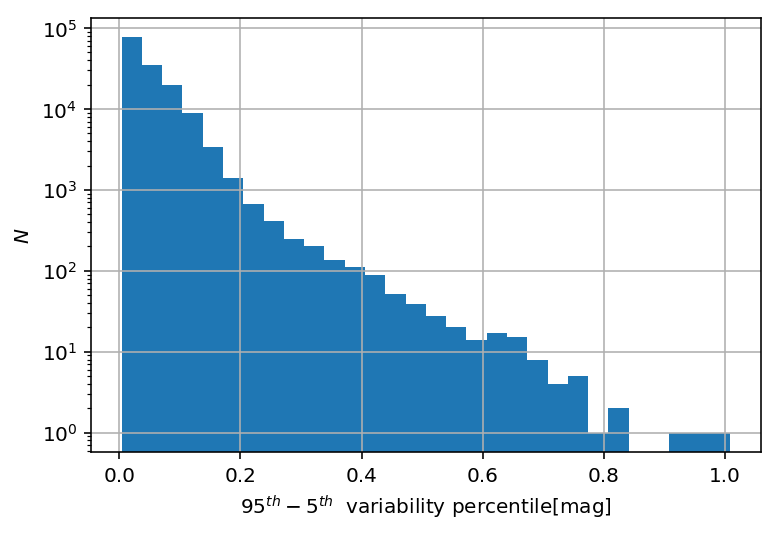

In [16]:
df_rotmod.max_activity_index.hist(bins=30)
plt.yscale('log')
plt.xlabel('$95^{th} - 5^{th}$  variability percentile[mag]')
plt.ylabel('$N$');

Wow, $>0.4$ magnitudes is a lot!  Most have much lower amplitudes.

The problem with *max* activity index is that it may be sensitive to *flares*.  Instead, let's use the $A$ and $B$ coefficients of the $\sin{}$ and $\cos{}$ functions:

>`segments_cos_term` : Coefficient of cosine term of linear fit in segment (double, Magnitude[mag])

>if a significative period T0 is detected in a time-series segment, then the points of the time-series segment are fitted with the function

$$mag(t) = mag_0 + A\cos(2\pi T_0 t) + B \sin(2\pi T_0 t)$$

Let's call the total amplitude $\alpha$, then we can apply:


$\alpha = \sqrt{A^2+B^2}$


In [17]:
val = df_rotmod.segments_cos_term[0]

In [18]:
val

'(0.006184367326778295, 0.0014396528754723747)'

Gasp!  The arrays are actually stored as strings!  We need to first convert them to numpy arrays.

In [19]:
np.array(eval(val))

array([0.00618437, 0.00143965])

In [20]:
NaN = np.NaN #Needed for all the NaN values in the strings.
clean_strings = lambda str_in: np.array(eval(str_in))

Only run this once:

In [21]:
if type(df_rotmod['segments_cos_term'][0]) == str:
    df_rotmod['segments_cos_term'] = df_rotmod['segments_cos_term'].apply(clean_strings)
    df_rotmod['segments_sin_term'] = df_rotmod['segments_sin_term'].apply(clean_strings)
else:
    print('Skipping rewrite.')

In [22]:
amplitude_vector = (df_rotmod.segments_sin_term**2 + df_rotmod.segments_cos_term**2)**0.5

In [23]:
df_rotmod['mean_amplitude'] = amplitude_vector.apply(np.nanmean)

Let's compare the `max_activity_index` with the newly determined mean amplitude.

The $95^{th}$ to $5^{th}$ percentile should be almost-but-not-quite twice the amplitude:

In [24]:
amp_conv_factor = 1.97537

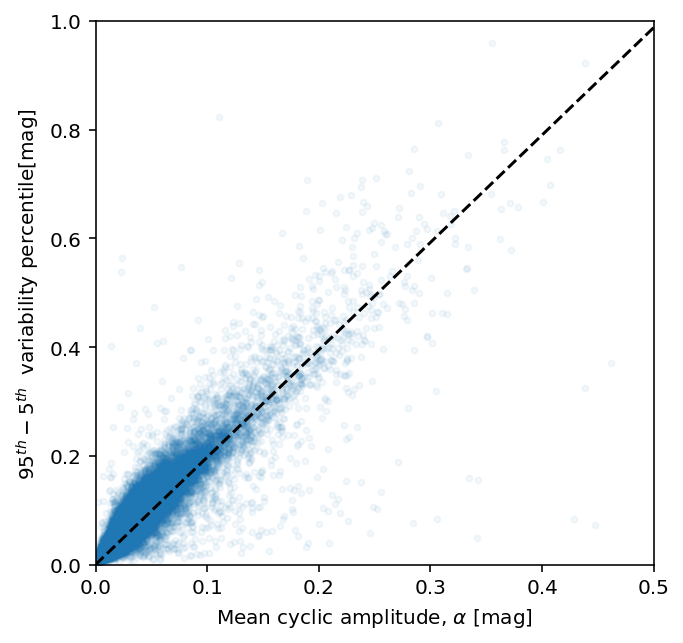

In [25]:
x_dashed = np.linspace(0,1, 10)
y_dashed = amp_conv_factor * x_dashed
plt.figure(figsize=(5,5))
plt.plot(df_rotmod.mean_amplitude, df_rotmod.max_activity_index, '.', alpha=0.05)
plt.plot(x_dashed, y_dashed, 'k--')
plt.xlim(0,0.5)
plt.ylim(0,1);
plt.xlabel(r'Mean cyclic amplitude, $\alpha$ [mag]')
plt.ylabel(r'$95^{th} - 5^{th}$  variability percentile[mag]');

The lines track decently well.  There's some scatter!  Probably in part due to non-sinusoidal behavior.

Let's convert the mean magnitude amplitude to an unspotted-to-spotted flux ratio:

In [26]:
df_rotmod['amplitude_linear'] = 10**(-df_rotmod.mean_amplitude/2.5)

(0.9, 1.01)

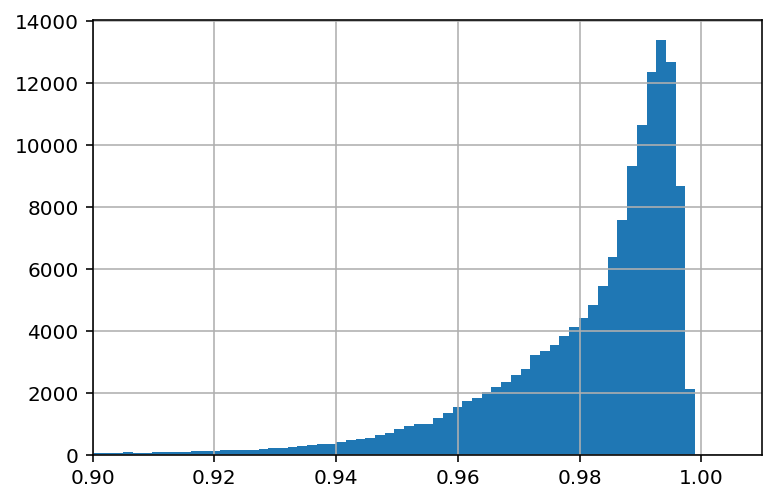

In [27]:
df_rotmod['amplitude_linear'].hist(bins=500)
plt.xlim(0.9, 1.01)

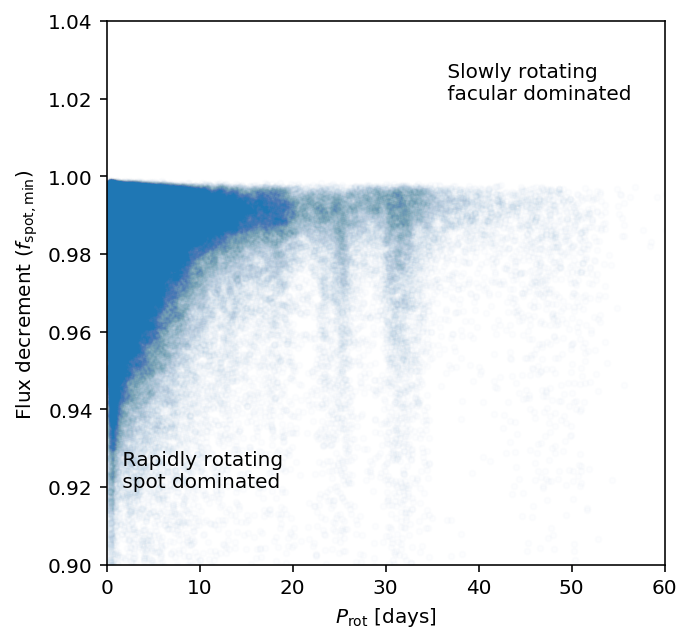

In [28]:
plt.figure(figsize=(5,5))
plt.plot(df_rotmod.best_rotation_period, df_rotmod.amplitude_linear, '.', alpha=0.01)
plt.xlim(0, 60)
plt.ylim(0.9, 1.04)
plt.xlabel('$P_{\mathrm{rot}}$ [days]')
plt.text(1, 0.92, ' Rapidly rotating\n spot dominated')
plt.text(36, 1.02, ' Slowly rotating\n facular dominated')
plt.ylabel('Flux decrement $(f_{\mathrm{spot, min}})$ ');

Promising!

Let's read in the Kepler data and cross-match!  This cross-match with Gaia and K2 data comes from Meg Bedell.

In [29]:
from astropy.table import Table
k2_fun = Table.read('../../K2-metadata/metadata/k2_dr2_1arcsec.fits', format='fits')

In [30]:
len(k2_fun), len(k2_fun.columns)

(288910, 95)

We only want a few of the 95 columns, so let's select a subset.

In [31]:
col_subset = ['source_id', 'epic_number', 'tm_name', 'k2_campaign_str']

In [32]:
k2_df = k2_fun[col_subset].to_pandas()

The `to_pandas()` method returns byte strings.  Arg!  We'll have to clean it.  Here is a reuseable piece of code:

In [33]:
def clean_to_pandas(df):
    '''Cleans a dataframe converted with the to_pandas method'''
    for col in df.columns:
        if type(k2_df[col][0]) == bytes:
            df[col] = df[col].str.decode('utf-8')
    return df

In [34]:
k2_df = clean_to_pandas(k2_df)

In [35]:
df_rotmod.columns

Index(['solution_id', 'source_id', 'num_segments', 'segments_start_time',
       'segments_end_time', 'segments_colour_mag_intercept',
       'segments_colour_mag_intercept_error', 'segments_colour_mag_slope',
       'segments_colour_mag_slope_error', 'segments_correlation_coefficient',
       'segments_correlation_significance', 'num_outliers', 'outliers_time',
       'segments_rotation_period', 'segments_rotation_period_error',
       'segments_rotation_period_fap', 'segments_cos_term',
       'segments_cos_term_error', 'segments_sin_term',
       'segments_sin_term_error', 'segments_a0_term', 'segments_a0_term_error',
       'best_rotation_period', 'best_rotation_period_error',
       'segments_activity_index', 'segments_activity_index_error',
       'max_activity_index', 'max_activity_index_error',
       'segments_g_unspotted', 'segments_g_unspotted_error',
       'segments_bp_unspotted', 'segments_bp_unspotted_error',
       'segments_rp_unspotted', 'segments_rp_unspotted_error',

In [36]:
keep_cols = ['source_id', 'num_segments', 'best_rotation_period', 'amplitude_linear']

We can **merge** (e.g. SQL *join*) these two dataframes on the `source_id` key.

In [37]:
k2_df.head()

,source_id,epic_number,tm_name,k2_campaign_str
0,2.641087e+18,60017806.0,2MASS J23342787-0134482,E
1,2.641087e+18,60017806.0,2MASS J23342787-0134482,E
2,2.634212e+18,60017809.0,2MASS J23293314-0346078,E
3,2.634212e+18,60017809.0,2MASS J23293314-0346078,E
4,2.740067e+18,60017810.0,2MASS J00043784+0333010,E


In [38]:
df_rotmod[keep_cols].head()

,source_id,num_segments,best_rotation_period,amplitude_linear
0,404707866294134912,2,6.819885,0.982152
1,404740679844116736,6,0.845407,0.994011
2,404817057245494784,4,1.026961,0.976839
3,404823482516792832,3,0.719850,0.986132
4,405068192572501760,3,0.319864,0.984646


We'll only keep columns that are in both catalogs.

In [39]:
df_comb = pd.merge(k2_df, df_rotmod[keep_cols], how='inner', on='source_id')

In [40]:
df_comb.head()

,source_id,epic_number,tm_name,k2_campaign_str,num_segments,best_rotation_period,amplitude_linear
0,2.44985e+18,60019808.0,2MASS J00011844-0050338,E,3,11.812471,0.991231
1,2.44985e+18,60020260.0,2MASS J00011919-0050496,E,3,11.812471,0.991231
2,3.59566e+18,201103864.0,2MASS J11581545-0628544,10,6,11.677781,0.990946
3,3.59735e+18,201149128.0,2MASS J12041716-0518533,10,3,2.062601,0.975344
4,3.5981e+18,201205375.0,2MASS J12080464-0358396,10,3,35.318797,0.992941


In [41]:
df_comb.shape

(524, 7)

Only 524 sources appear in both catalogs!  Boo!  Well, better than nothing!  
It's actually even fewer K2 targets, since some targets are single in K2 but have two or more matches in Gaia.  These could be background stars or bona-fide binaries.  Let's flag them.

In [42]:
multiplicity_count = df_comb.groupby('epic_number').\
                            source_id.count().to_frame().\
                            rename(columns={'source_id':'multiplicity'})

In [43]:
df = pd.merge(df_comb, multiplicity_count, left_on='epic_number', right_index=True)

In [44]:
df.head(20)

,source_id,epic_number,tm_name,k2_campaign_str,num_segments,best_rotation_period,amplitude_linear,multiplicity
0,2.44985e+18,60019808.0,2MASS J00011844-0050338,E,3,11.812471,0.991231,1
1,2.44985e+18,60020260.0,2MASS J00011919-0050496,E,3,11.812471,0.991231,1
2,3.59566e+18,201103864.0,2MASS J11581545-0628544,10,6,11.677781,0.990946,1
3,3.59735e+18,201149128.0,2MASS J12041716-0518533,10,3,2.062601,0.975344,1
4,3.5981e+18,201205375.0,2MASS J12080464-0358396,10,3,35.318797,0.992941,1
5,3.60178e+18,201249315.0,2MASS J11543852-0313049,1,4,5.208817,0.965566,1
6,3.60116e+18,201272989.0,2MASS J12000551-0251359,1,3,16.250582,0.989781,8
7,3.60116e+18,201272989.0,2MASS J12000551-0251359,10,3,16.250582,0.989781,8
8,3.60116e+18,201272989.0,2MASS J12000551-0251359,1,3,16.250582,0.989781,8
9,3.60116e+18,201272989.0,2MASS J12000551-0251359,10,3,16.250582,0.989781,8


Let's cull the list and just use the "single" stars, which is really the sources for which Gaia did not identify more than one target within 1 arcsecond.

In [45]:
df_single = df[df.multiplicity == 1]

In [46]:
df_single.shape

(224, 8)

A mere 224 sources!  Boo hoo!

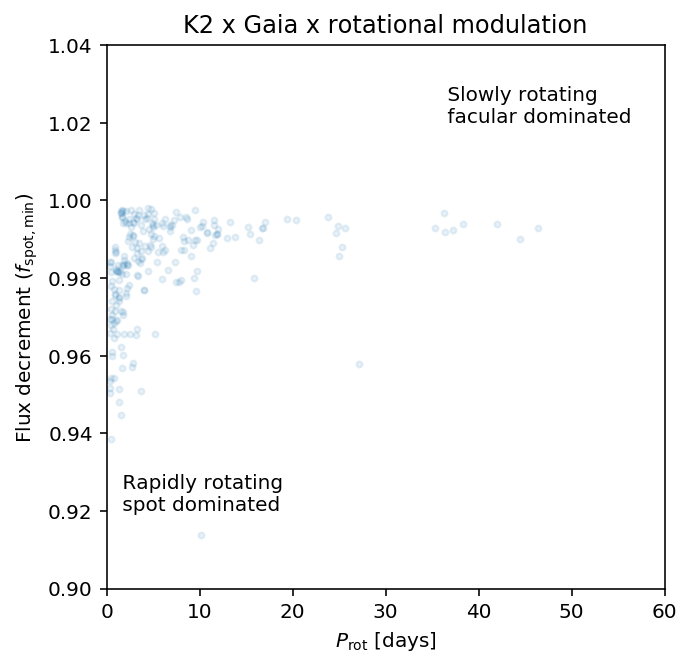

In [47]:
plt.figure(figsize=(5,5))
plt.plot(df_single.best_rotation_period, df_single.amplitude_linear, '.', alpha=0.1)
plt.xlim(0, 60)
plt.ylim(0.9, 1.04)
plt.xlabel('$P_{\mathrm{rot}}$ [days]')
plt.text(1, 0.92, ' Rapidly rotating\n spot dominated')
plt.text(36, 1.02, ' Slowly rotating\n facular dominated')
plt.ylabel('Flux decrement $(f_{\mathrm{spot, min}})$ ')
plt.title('K2 x Gaia x rotational modulation');

The points look drawn from their parent population.

In [48]:
df_single.sort_values('amplitude_linear', ascending=True).head(25).style.format({'source_id':"{:.0f}",
                                                                                 'epic_number':"{:.0f}"})

,source_id,epic_number,tm_name,k2_campaign_str,num_segments,best_rotation_period,amplitude_linear,multiplicity
275,658580423924208896,211836630,2MASS J08442233+1750080,16,3,0.368447,0.898086,1
250,659839437753487232,211823646,2MASS J08501034+1739076,5,4,10.1974,0.913926,1
197,655472658605271936,211685886,2MASS J08182325+1543301,5,3,0.469649,0.938647,1
121,598514653454617344,211323984,2MASS J08472356+1019588,5,4,1.49577,0.944613,1
122,598387870315169792,211328300,2MASS J08431825+1024481,5,3,1.32871,0.947946,1
365,664570430130197376,212005402,2MASS J08342639+2020413,16,3,0.316894,0.950434,1
85,65414761397616512,210993662,2MASS J03561519+2252292,4,3,3.66327,0.951003,1
496,3682573958240910848,228938222,2MASS J12491095-0236088,10,3,1.31117,0.951336,1
113,66957994687842176,211149600,2MASS J03503571+2525354,4,3,0.314485,0.95171,1
99,66453181412027392,211047055,2MASS J03495762+2343284,4,3,0.314441,0.953438,1


Let's see if we can examine some of these Gaia lightcurves and compare them to K2 lightcurves.  We'll do that in the next notebook.